# Analyze the embeddings of self-supervised techniques

### First look at what angle and angular distance can do for us

In [3]:
import numpy as np
import matplotlib.pyplot as plt
ref = np.zeros((256))
ref[0] = 1.0
ref


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [11]:
np.random.seed(1)
a = np.random.rand(256)
b = np.random.rand(256)

In [12]:
from numpy import dot, arccos
from numpy.linalg import norm

def compute_angle(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    print(cos_sim)
    sigma = arccos(cos_sim)
    print(sigma)

In [13]:
compute_angle(a,b)
compute_angle(b,a)

0.7263647176887275
0.7577784159461743
0.7263647176887275
0.7577784159461743


In [14]:
compute_angle(ref,a)
compute_angle(ref,b)

0.04437593638721887
1.5264058131284828
0.061525027226413134
1.5092324178896508


### try looking at embeddings

In [11]:
import torch
from dataloader import DataLoaderCustom
from utils import serialize, deserialize
from train import prep_triplets

# %load_ext autoreload
# %autoreload 2

In [12]:
class AttrDict(dict): 
    # allows attribute referencing (i.e. with periods, like arg parser outputs)
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [13]:
USE_GPU = True
print("GPU detected?", torch.cuda.is_available())
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print("\nNote: gpu available & selected!")
else:
    device = torch.device('cpu')
    print("\nNote: gpu NOT available!")

print(device)

GPU detected? True

Note: gpu available & selected!
cuda


In [14]:
model_path = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background_epoch1.pt"

dataloader_type = "hdf5_triplets"
patch_loading = "random"
data_path = "/home/data/tinycam/train/train.hdf5"
batch_size = 5 # single triplets
channel_dim = 3
patch_size = 224
dataset_name = "cam"
labeldict_path = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"
label_dict = deserialize(labeldict_path)
triplet_list = "/home/data/tinycam/train/triplets0_list.obj"

args = AttrDict({"patch_size": patch_size, "dataloader_type": dataloader_type, "channel_dim": channel_dim, "label_dict":label_dict, "dataset_name": dataset_name, "batch_size": batch_size, "patch_loading": patch_loading, "data_path": data_path, "triplet_list": triplet_list})
dataloader0 = DataLoaderCustom(args)


In [15]:
import matplotlib.pyplot as plt

In [30]:
def inference(model_path, dataloader, device, patch_class=0, num_triplets=10):
    model = torch.load(model_path, map_location=device)
    model.eval()
    embeds = []

    with torch.no_grad():
        for idx, (fxy, triplets, y) in enumerate(dataloader):
            print("triplet #:", idx)
            if idx > num_triplets:
                break
            p, n, d = prep_triplets(triplets, device)
            zp = model.encode(p)
            zn = model.encode(n)
            zd = model.encode(d)
            if idx == 0:
                xs = [p, n, d]
                print("preview of patches (rows = triplets, cols = {anchor, neighbor, distant}):")
                fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
                for i, row in enumerate(ax):
                    for j, col in enumerate(row):
                        x = xs[j].cpu().numpy()
                        B,D,H,W = x.shape
                        x = x.reshape(B,H,W,D)
                        col.imshow(x[i,:,:,:].astype('uint8'))
                print("shape of embeddings:", zn.shape)
            embeds.extend([zp, zn, zd])
    
    torch.save(embeds, "/home/cache/cam/embed_ss-" + str(patch_class) + ".obj") # used to be serialize
    

triplet #: 0
preview of patches (rows = triplets, cols = {anchor, neighbor, distant}):
shape of embeddings: torch.Size([5, 512])
triplet #: 1
triplet #: 2
triplet #: 3
triplet #: 4
triplet #: 5
triplet #: 6
triplet #: 7
triplet #: 8
triplet #: 9
triplet #: 10
triplet #: 11


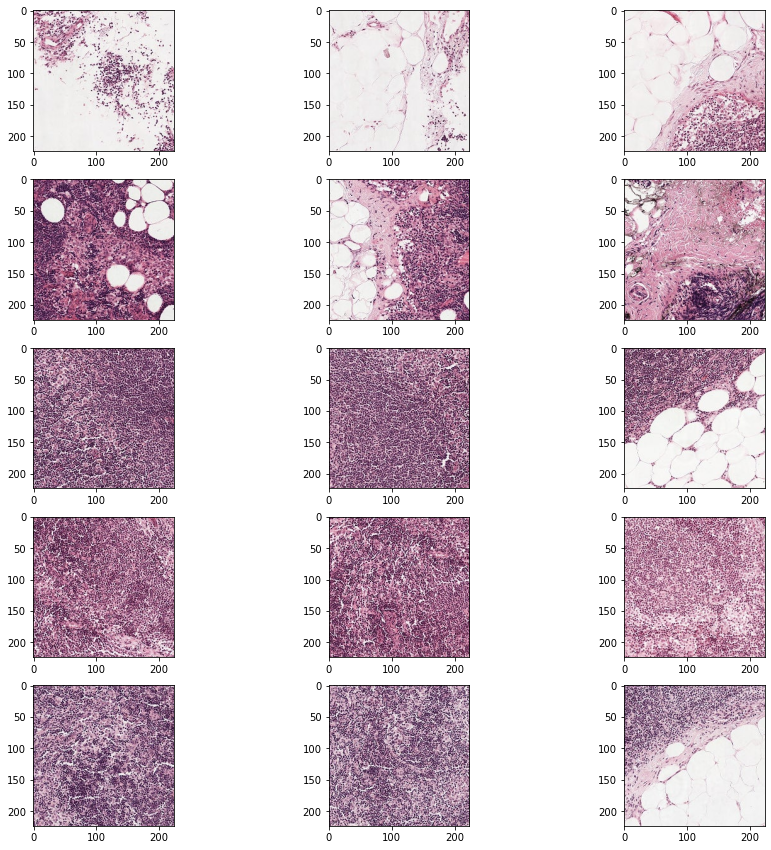

In [31]:
inference(model_path, dataloader0, device, patch_class=0)

In [7]:
del dataloader0
triplet_list = "/home/data/tinycam/train/triplets1_list.obj"
args.triplet_list = triplet_list # update
dataloader1 = DataLoaderCustom(args)

inference(model_path, dataloader1, device, patch_class=1)

triplet #: 0
shape of embeddings: torch.Size([5, 512])
triplet #: 1
triplet #: 2
triplet #: 3
triplet #: 4
triplet #: 5
triplet #: 6
triplet #: 7
triplet #: 8
triplet #: 9
triplet #: 10
triplet #: 11


### time to view

In [8]:
embeds_0 = torch.load("/home/cache/cam/embed_ss-0.obj")
embeds_1 = torch.load("/home/cache/cam/embed_ss-1.obj")
embeds_list = embeds_0 + embeds_1

In [9]:
e_list = []
for e in embeds_list:
    e = e.cpu().detach().numpy()
    e_list.append(e)

In [10]:
from sklearn.manifold import TSNE
from tkinter.ttk import LabeledScale
import numpy as np
import matplotlib.pyplot as plt

def plot_tsne_embeds(embeds_list, num_triplets=10):
    array = np.vstack(embeds_list)
    print(array.shape)
    labs0 = np.zeros(((num_triplets+1)*3*batch_size, 1)) 
    labs1 = np.ones(((num_triplets+1)*3*batch_size, 1)) 
    labs = np.vstack([labs0, labs1])

    # tsne
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(array)
    print(X_embedded.shape)
    plt.figure()
    plt.xlabel("tSNE-0")
    plt.ylabel("tSNE-1")
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labs, alpha=0.5, cmap="Dark2")


(330, 512)
(330, 2)


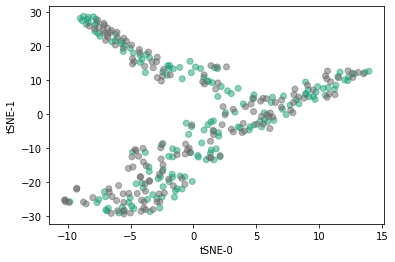

In [11]:
plot_tsne_embeds(e_list)

### check the magnitudes and max distances of embeddings

In [12]:
array = np.vstack(e_list)
n,p =  array.shape
dists = []
mags = []
for i in range(n):
    e = array[i,:]
    mags.append(np.linalg.norm(e)) # l2 norm
    if i < n-1:
        e_other = array[i+1,:]
        dists.append(np.linalg.norm(e-e_other))


(array([22., 38., 33., 43., 38., 42., 50., 38., 21.,  4.]),
 array([ 1.853812 ,  4.0436196,  6.233427 ,  8.423234 , 10.613042 ,
        12.802849 , 14.992657 , 17.182465 , 19.37227  , 21.562078 ,
        23.751886 ], dtype=float32),
 <BarContainer object of 10 artists>)

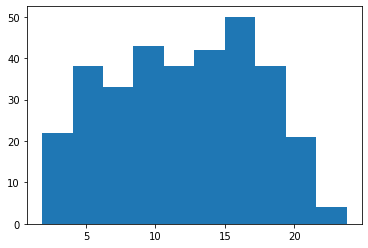

In [13]:
plt.hist(dists)

(array([22., 94., 79., 32., 24., 21., 22., 15., 14.,  7.]),
 array([ 6.56518 ,  7.861543,  9.157907, 10.45427 , 11.750633, 13.046997,
        14.343361, 15.639724, 16.936087, 18.23245 , 19.528814],
       dtype=float32),
 <BarContainer object of 10 artists>)

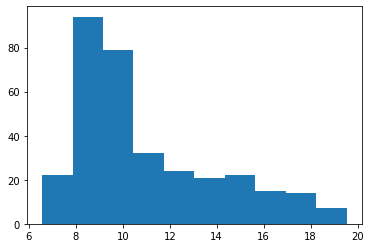

In [14]:
plt.hist(mags)